Library Import

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Data Preprocessing

In [2]:
data = pd.read_csv("C:/Users/aberg/OneDrive/Desktop/mouse_data.csv", index_col = 0)
data = data.T
data['cell_type'] = data.index
data['cell_type'] = data['cell_type'].str.split('.').str[0]

In [3]:
# Separate features and labels
X = data.drop(columns=['cell_type']).values  # Features
y = data['cell_type'].values  # Labels)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

array([3, 3, 3, ..., 1, 1, 4])

Splitting into test and train, normalize features

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Convert to tensors

In [5]:
# NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [6]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

Define classes for performing operations and functions for running analysis

In [7]:
# Neural network architecture 1
class Net1(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net1, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.fc2 = nn.Linear(8, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Neural network architecture 2
class Net2(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    total_loss = 0.0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute total loss
        total_loss += loss.item()
        
        # Count correct predictions
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate average loss and accuracy
    avg_loss = total_loss / size
    accuracy = correct / size
    return avg_loss, accuracy

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Calculate average loss and accuracy
    avg_loss = test_loss / size
    accuracy = correct / size
    return avg_loss, accuracy
   
    
experiments_architecture1 = [
    {"learning_rate": 1e-5, "batch_size": 64, "optimizer": optim.Adam, "loss_fn": nn.CrossEntropyLoss},
    {"learning_rate": 1e-3, "batch_size": 128, "optimizer": optim.Adam, "loss_fn": nn.CrossEntropyLoss},
    {"learning_rate": 1e-5, "batch_size": 64, "optimizer": optim.SGD, "loss_fn": nn.CrossEntropyLoss},
    {"learning_rate": 1e-3, "batch_size": 128, "optimizer": optim.SGD, "loss_fn": nn.CrossEntropyLoss}
]


experiments_architecture2 = [
    {"learning_rate": 1e-5, "batch_size": 64, "optimizer": optim.Adam, "loss_fn": nn.CrossEntropyLoss},
    {"learning_rate": 1e-3, "batch_size": 128, "optimizer": optim.Adam, "loss_fn": nn.CrossEntropyLoss},
    {"learning_rate": 1e-5, "batch_size": 64, "optimizer": optim.SGD, "loss_fn": nn.CrossEntropyLoss},
    {"learning_rate": 1e-3, "batch_size": 128, "optimizer": optim.SGD, "loss_fn": nn.CrossEntropyLoss}
]

# Function to run experiments
def run_experiment(architecture, config):
    input_size = X_train.shape[1]
    num_classes = len(data['cell_type'].unique())  # Assuming cell types are unique

    if architecture == 'architecture1':
        model = Net1(input_size, num_classes)
    elif architecture == 'architecture2':
        model = Net2(input_size, num_classes)

    learning_rate = config["learning_rate"]
    batch_size = config["batch_size"]
    optimizer = config["optimizer"](model.parameters(), lr=learning_rate)
    loss_fn = config["loss_fn"]()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs = 20  
    for t in range(epochs):
        # Training loop
        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Testing loop
        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    return train_losses, train_accuracies, test_losses, test_accuracies

def plot_losses_and_accuracies(train_losses, train_accuracies, test_losses, test_accuracies, architecture_name):
    epochs = len(train_losses)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot training and testing loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{architecture_name} - Training and Testing Loss')
    plt.legend()

    # Plot training and testing accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{architecture_name} - Training and Testing Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Run experiments

Running Experiment 1 for Architecture 1


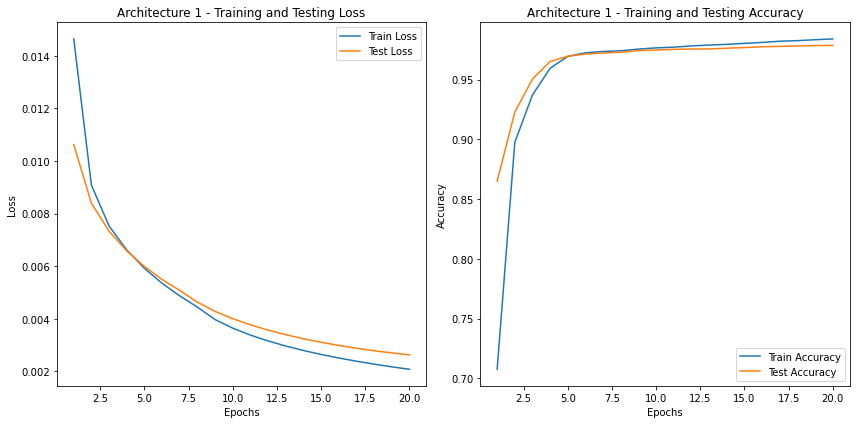

Running Experiment 2 for Architecture 1


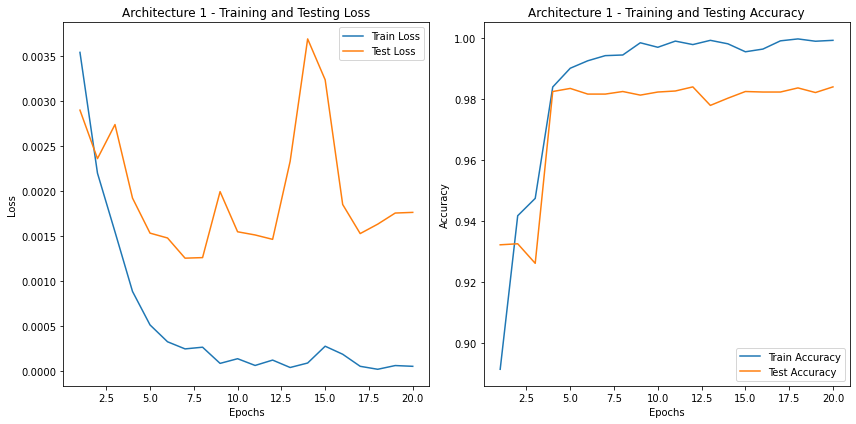

Running Experiment 3 for Architecture 1


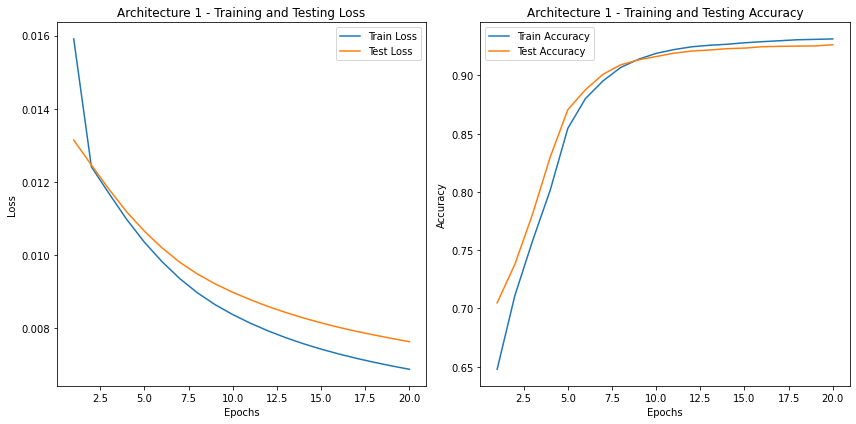

Running Experiment 4 for Architecture 1


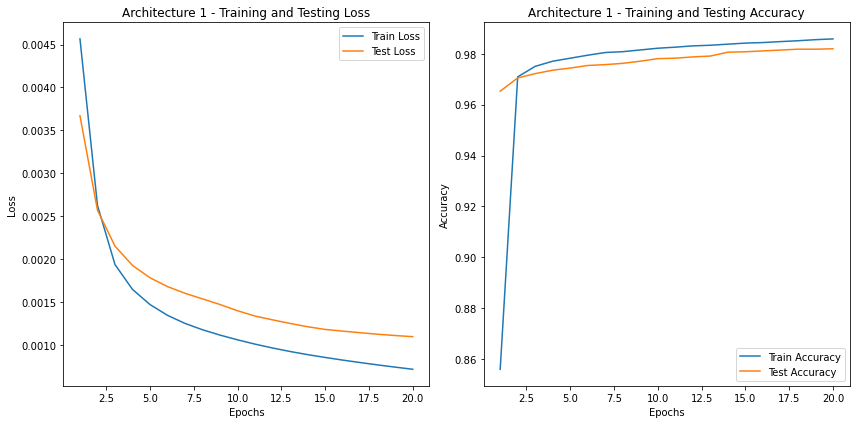

Running Experiment 1 for Architecture 2


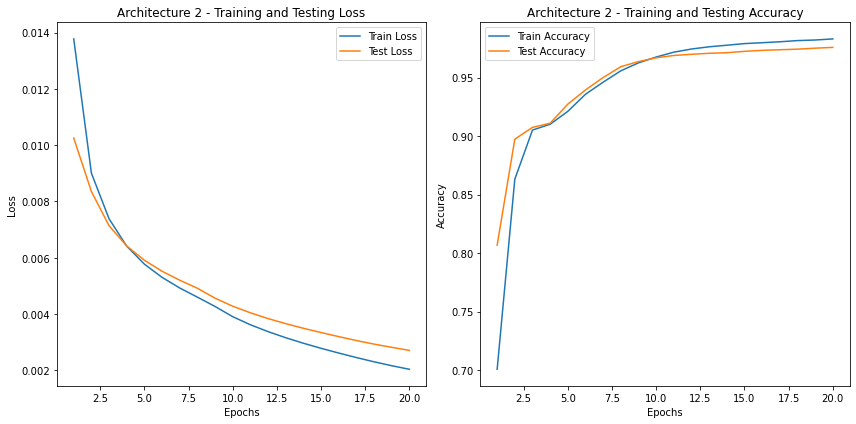

Running Experiment 2 for Architecture 2


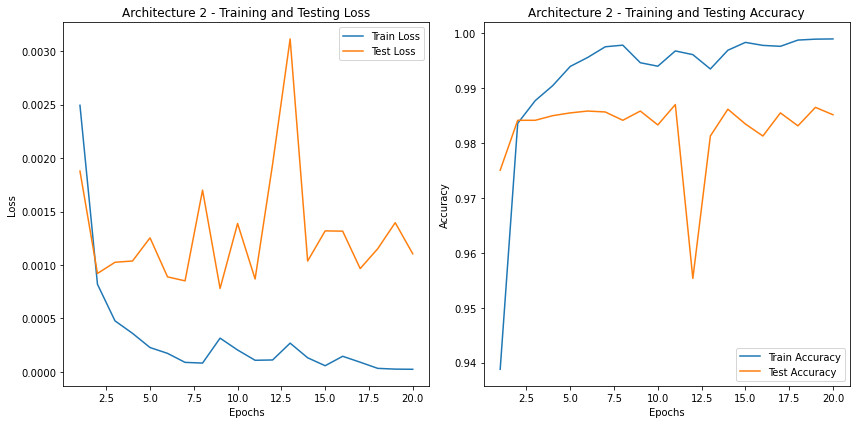

Running Experiment 3 for Architecture 2


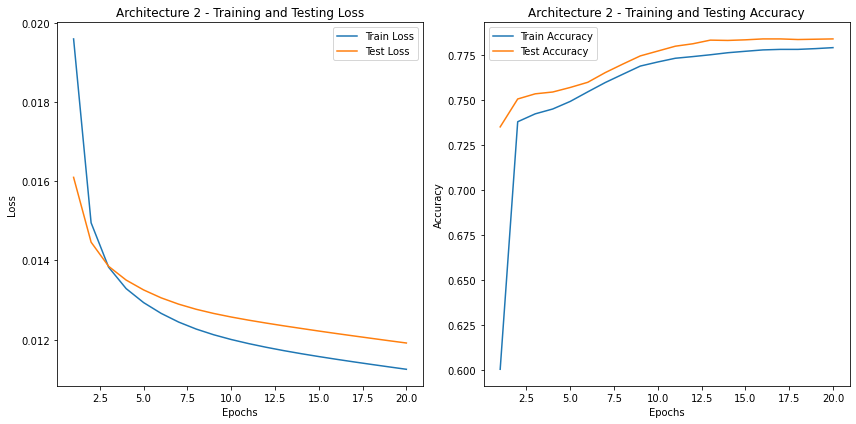

Running Experiment 4 for Architecture 2


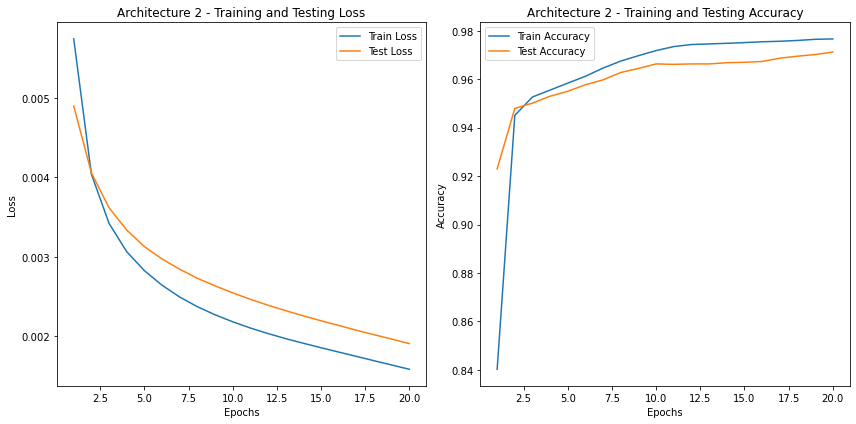

In [8]:
# Run experiments for architecture 1
for i, config in enumerate(experiments_architecture1):
    print(f"Running Experiment {i+1} for Architecture 1")
    train_losses, train_accuracies, test_losses, test_accuracies = run_experiment('architecture1', config)
    # Plot losses and accuracies
    plot_losses_and_accuracies(train_losses, train_accuracies, test_losses, test_accuracies, "Architecture 1")
    # Print or save results as needed

# Run experiments for architecture 2
for i, config in enumerate(experiments_architecture2):
    print(f"Running Experiment {i+1} for Architecture 2")
    train_losses, train_accuracies, test_losses, test_accuracies = run_experiment('architecture2', config)
    # Plot losses and accuracies
    plot_losses_and_accuracies(train_losses, train_accuracies, test_losses, test_accuracies, "Architecture 2")
    # Print or save results as needed